# Trajectory Tracking with Integral Loss

In [ ]:
import sys
sys.path.append('../')
from torchdyn.models import *; from torchdyn import *

## Integral Loss

We consider a loss of type

$$
    \ell_\theta := \int_0^S g(z(s))d\tau
$$

where $z(s)$ satisfies the neural ODE initial value problem 

$$
    \left\{
    \begin{aligned}
        \dot{z}(s) &= f(z(s), \theta(s))\\
        z(0) &= x
    \end{aligned}
    \right. \quad s\in[0,S]
$$

where $\theta(s)$ is parametrized with some spectral method (`Galerkin-style`),  i.e. $\theta(s)=\theta(s,\omega)$ [$\omega$: parameters of $\theta(s)$].

**REMARK:** In `torchdyn`, we do not need to evaluate the following integral in the forward pass of the ODE integration.
In fact, we will compute the gradient $d\ell/d\omega$ just by solving backward 

$$
    \begin{aligned}
        \dot\lambda (s) &= -\frac{\partial f}{\partial z}\lambda(s) + \frac{\partial g}{\partial z} \\
        \dot\mu (s) &= -\frac{\partial f}{\partial \theta}\frac{\partial \theta}{\partial \omega}\lambda(s)
    \end{aligned}~~\text{with}~~
    \begin{aligned}
        \lambda (S) &= 0\\
        \mu (S) &= 0
    \end{aligned}
$$

and, $\frac{d\ell}{d\omega} = \mu(0)$. Check out [this paper](https://arxiv.org/abs/2003.08063) for more details on the integral adjoint for Neural ODEs.

**Example:** Use a neural ODE to track a 2D curve $\gamma:[0,\infty]\rightarrow \mathbb{S}_2$ ($\mathbb{S}_2$: unit circle, $\mathbb{S}_2:=\{x\in\mathbb{R}^2:||x||_2=1\}$), i.e.

$$
    \gamma(s) := [\cos(2\pi s), \sin(2\pi s)]
$$

which has periodicity equal to $1$: $\forall n\in\mathbb{N}, \forall s\in[0,\infty]~~\gamma(s) = \gamma(ns)$.

Let suppose to train the neural ODE for $s\in[0,1]$. Therefore we can easily setup the integral cost as

$$
    \ell_\theta := \int_0^1 ||h(\tau)-\gamma(\tau)||_2^2 d\tau
$$

In [36]:
class IntegralLoss(nn.Module):
    def __init__(self):
        super().__init__()
        
    def y(self, s):
        return torch.tensor([torch.cos(2*np.pi*s), torch.sin(2*np.pi*s)]).to(device)
        
    def forward(self, s, x):
        int_loss = (torch.norm(self.y(s)-x, p=2, dim=1)**2).mean()
        print(f'\rIntegral loss: {int_loss}', end='')
        return int_loss

**Note:** In this case we do not define any dataset of initial conditions and load it into the dataloader. Instead, at each step, we will sample new ICs from a normal distrubution centered in $\gamma(0) = [1,0]$

$$
    x_t \sim \mathcal{N}(\gamma(0),0.1)
$$

However, we still need to define a "dummy" `trainloader` to "trick" `pythorch_lightning`'s API.

In [37]:
# dummy trainloader
train = torch.utils.data.TensorDataset(torch.zeros(1), torch.zeros(1))
trainloader = torch.utils.data.DataLoader(train, batch_size=1, shuffle=True)

**Learner**

In [43]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Learner(pl.LightningModule):
    def __init__(self, model:nn.Module):
        super().__init__()
        self.model = model
        
    def forward(self, x):
        return self.model(x)    
    
    def training_step(self, batch, batch_idx):    
        # We sample from Normal distribution around "nominal" initial condition
        x = torch.tensor([1.,0.])
        x = x + 0.1*torch.randn(2048, 2)
        y_hat = self.model(x.to(device))
        # We need to evaluate a "dummy loss" (just the summed output of the model)
        # to construct the graph for the 'backward()' "triggering" the integral adjoint 
        loss = 0.*y_hat.sum()
        tensorboard_logs = {'train_loss': loss}
        # At traing we expect `loss` to be 1
        return {'loss': loss, 'log': tensorboard_logs}   
    
    def configure_optimizers(self):
        return torch.optim.RMSprop(self.model.parameters(), lr=0.001)

    def train_dataloader(self):
        return trainloader

## Parameter Varying Neural ODE

**Model**

In [48]:
# We use a Galerkin Neural ODE with one hidden layer, 
# Fourier spectrum (period=1) and only 4 freq.s
f = nn.Sequential(DepthCat(1),
                  GalLinear(2, 64, 
                            FourierExpansion, 
                            n_harmonics=4,
                            dilation=False,
                            shift=False),
                  nn.Tanh(),
                  nn.Linear(64, 2, bias=False))

# Define the model
model = NeuralDE(f, 
                 solver='dopri5',
                 sensitivity='adjoint',
                 atol=1e-6,
                 rtol=1e-6,
                 intloss=IntegralLoss()).to(device)

In [49]:
# Train the model
learn = Learner(model)
trainer = pl.Trainer(min_epochs=1500, max_epochs=1500, gpus=1)
trainer.fit(learn)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params
-----------------------------------
0 | model | NeuralDE | 1 K   
/home/jyp/michael_dev/testenv/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:25: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Integral loss: 0.04068374261260033425


1

**Plots**

We first evaluate the model on a test set of initial conditions sampled from $\mathcal{N}(\gamma(0),\sigma\mathbb{I})$. Since we trained the neural ODE with $\sigma=0.1$, now we test it with $\sigma=0.2$.

In [46]:
s_span = torch.linspace(0, 5, 500)
x_test = torch.tensor([1.,0.])
x_test = x_test + 0.1*torch.randn(100, 2)
trajectory = model.trajectory(x_test.to(device), s_span).detach().cpu()

**Depth evolution of the system** -> The system is trained for $s\in[0,1]$ and then we extrapolate until $s=5$

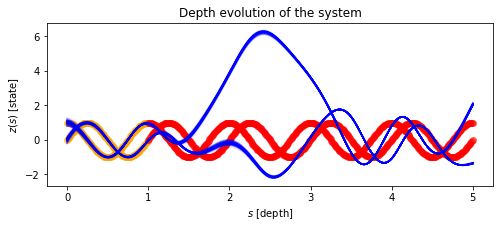

In [47]:
y1 = np.cos(2*np.pi*s_span)
y2 = np.sin(2*np.pi*s_span)

fig = plt.figure(figsize=(8,3))
ax = fig.add_subplot(111)
ax.scatter(s_span[:100], y1[:100], color='orange',alpha=0.5)
ax.scatter(s_span[:100], y2[:100], color='orange',alpha=0.5)
ax.scatter(s_span[100:], y1[100:], color='red',alpha=0.5)
ax.scatter(s_span[100:], y2[100:], color='red',alpha=0.5)
for i in range(len(x_test)):
    ax.plot(s_span, trajectory[:,i,:], color='blue', alpha=.1)
ax.set_xlabel(r"$s$ [depth]")
ax.set_ylabel(r"$z(s)$ [state]")
ax.set_title(r"Depth evolution of the system");

**State-space trajectories**
-> All the (random) IC converge to the desired trajectory

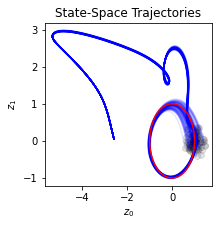

In [23]:
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111)
for i in range(len(x_test)):
    ax.plot(trajectory[:,i,0], trajectory[:,i,1], color='blue', alpha=.1)
    ax.scatter(trajectory[0,i,0], trajectory[0,i,1], color='black', alpha=.1)
ax.plot(y1[:100],y2[:100], color='red')
ax.set_xlabel(r"$z_0$")
ax.set_ylabel(r"$z_1$")
ax.set_title(r"State-Space Trajectories");